In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px

%matplotlib inline

style.use("fivethirtyeight")

# Estimating treatment effect using Difference in Difference Technique

This notebook provides code to estimate treatment effect using the classic Diff-in-Diff quasi-experimental design.

## Our model
We will be comparing our treatment group before and after an intervention, and using a control group to help us create a counterfactual in order to estimate our tretment effect.

The regression model would be:

Y= β0 + β1*[Time] + β2*[Intervention] + β3*[Time * Intervention] + ε

And one important assumption is the 'parallel trends assumption' which basically means that if we plot our metric over time before the intervention the trends of the control and treatment groups should be parallel (by visual inspection).




# The code

The code bellow is a function with the following inputs and outputs.

Inputs:

*   Dataframe with 3 columns, where each observation is a treatment unit (ieg: user):
  1.   Treatment indicator as a binary variable
  2.   Time indicator (before or after the intervention) as a binary variable
  3.   Metric value for the respective treatment and time

Outputs:

*   Plot with before and after values for control group, treatment group and treatment group counterfactual.
*   Estimated effect + confidence interval of the estimate
*   Hypothesis test result (statistically significant or not)


In [2]:
# Function to calculate diff-in-diff estimator and statistical significance
# Important: the dataframe needs to have a 'treatment' column with 1 for treatment group and 0 for control group
# Important: the dataframe needs to have a 'period' column with 0 for before treatment applied and 1 for after treatment applied


def did_estimator(df, metric):
  # Using standard alpha
  alpha=0.05

  # Calculate the Diff-in-Diff estimator
  treatment_before = df.query("treatment==1 and period==0")[metric].mean()
  treatment_after = df.query("treatment==1 and period==1")[metric].mean()
  control_before = df.query("treatment==0 and period==0")[metric].mean()
  control_after = df.query("treatment==0 and period==1")[metric].mean()
  effect = (treatment_after - treatment_before) - (control_after - control_before)

  # Create linear regression model
  model_summary = smf.ols(f'{metric} ~ treatment*period', data=df).fit(alpha=alpha).summary()

  # Get the p-value
  p_value = float(model_summary.tables[1].data[4][4])

  # Get the lower and upper bounds of the confidence interval for impact
  lower_bound = float(model_summary.tables[1].data[4][5])
  upper_bound = float(model_summary.tables[1].data[4][6])


  # Calculate percentage change for lower and upper bounds
  percentage_change = ((effect) / (treatment_before + (control_after - control_before))) * 100
  percentage_change_lower = ((lower_bound) / (treatment_before + (control_after - control_before))) * 100
  percentage_change_upper = ((upper_bound) / (treatment_before + (control_after - control_before))) * 100

  # Create a figure and axis objects
  fig, ax = plt.subplots(figsize=(10, 5))

  # Plot the data
  ax.plot(["Before", "After"], [control_before, control_after], label="Control", lw=2)
  ax.plot(["Before", "After"], [treatment_before, treatment_after], label="Treatment", lw=2)

  ax.plot(["Before", "After"], [treatment_before, treatment_before + (control_after - control_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

  ax.set_title(f'Difference in Difference for {metric} metric')
  ax.legend()

  # Display the plot
  plt.show()

  # Print estimated change as a % and the confidence interval of the estimation
  print(f'Estimated relative effect = {percentage_change:.2f}% with a 95% CI of [{percentage_change_lower:.2f}%, {percentage_change_upper:.2f}%]')

  # Check p-value against alpha level and print statistical significance
  if p_value < alpha:
      print(f"With a p-value of {p_value} and a confidence level of {(1-alpha)*100}% the results are statistically significant!")
  else:
      print(f"With a p-value of {p_value} and a confidence level of {(1-alpha)*100}% the results are NOT statistically significant!")

# Example

In [3]:
# dataset from Matheus Facure https://github.com/matheusfacure/python-causality-handbook

df_billboard = pd.read_csv(
    filepath_or_buffer = 'https://raw.githubusercontent.com//gsrubio/portfolio/main/datasets/billboard_impact.csv',
    sep=',',
    decimal='.'
)


In [4]:
df_billboard.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


In [5]:
# treatment: 0 equals control; 1 equals treatment variant
# period: 0 means befor treatment applied; 1 means after treatment applied
df_billboard = df_billboard.rename(columns={'poa':'treatment', 'jul':'period'})

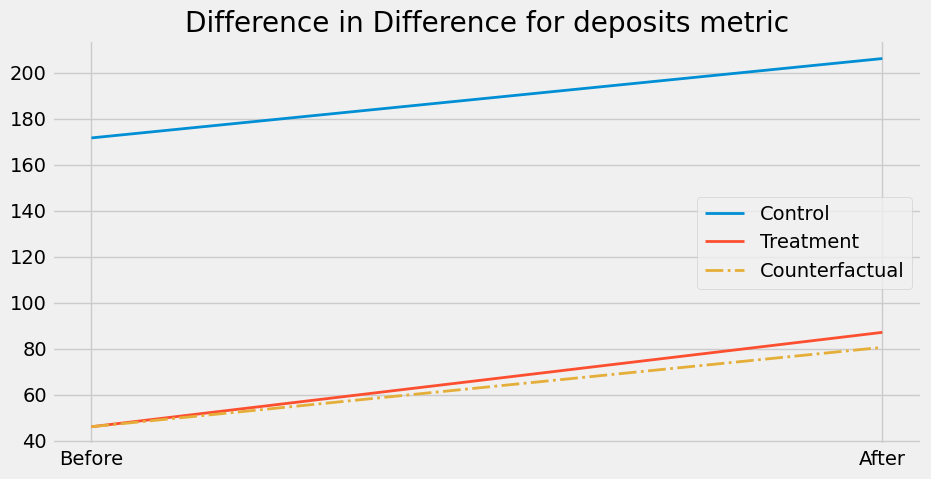

Estimated relative effect = 8.10% with a 95% CI of [-5.84%, 22.05%]
With a p-value of 0.255 and a confidence level of 95.0% the results are NOT statistically significant!


In [6]:
did_estimator(df=df_billboard, metric='deposits')

# References
- this code was inspired by [this chapter](https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html) of Matheus Facure's book 'Causal Inference for The Brave and True
- this [article](https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation) from Columbia University is also a great introduction to DiD